In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict
from joblib import Parallel, delayed
from tqdm import tqdm

import sys
sys.path.insert(0, '../src')
import geopandas as gpd
from postprocess_detections import process_mgrs_tile
from joblib import Parallel, delayed
import pandas as pd
from tqdm import tqdm


class SimpleSpatialSplitter:
    """
    A simple spatial-aware splitter that maintains polygon integrity
    while aiming for approximate size balance.
    """
    def __init__(self, test_size=0.2, random_state=None):
        self.test_size = test_size
        self.random_state = random_state
        np.random.seed(random_state)
    
    def split_positives(self, positives_df, polygon_id_col):
        """Split positive samples keeping polygons intact."""
        # Get polygon sizes
        polygon_sizes = positives_df.groupby(polygon_id_col).size()
        total_samples = polygon_sizes.sum()
        
        # Shuffle polygon IDs
        polygon_ids = list(polygon_sizes.index)
        np.random.shuffle(polygon_ids)
        
        # Assign polygons to train/test
        test_polygons = []
        test_count = 0
        target_test = total_samples * self.test_size
        
        # Keep adding polygons to test until we reach approximate target
        for pid in polygon_ids:
            if test_count < target_test:
                test_polygons.append(pid)
                test_count += polygon_sizes[pid]
            
        # Create masks
        train_mask = ~positives_df[polygon_id_col].isin(test_polygons)
        test_mask = positives_df[polygon_id_col].isin(test_polygons)
        
        return np.where(train_mask)[0], np.where(test_mask)[0]
    
    def split(self, X, y, polygon_id_col=None, class_col=None):
        """Perform the complete train-test split."""
        positives_mask = y == 1
        negatives_mask = y == 0
        
        # Split positive samples by polygon
        pos_train_idx, pos_test_idx = self.split_positives(
            X[positives_mask].reset_index(drop=True),
            polygon_id_col
        )
        
        # Split negative samples with stratification if class_col provided
        neg_train_idx, neg_test_idx = train_test_split(
            np.arange(negatives_mask.sum()),
            test_size=self.test_size,
            stratify=X[negatives_mask][class_col] if class_col else None,
            random_state=self.random_state
        )
        
        # Combine indices
        all_pos_idx = np.where(positives_mask)[0]
        all_neg_idx = np.where(negatives_mask)[0]
        
        train_idx = np.concatenate([
            all_pos_idx[pos_train_idx],
            all_neg_idx[neg_train_idx]
        ])
        test_idx = np.concatenate([
            all_pos_idx[pos_test_idx],
            all_neg_idx[neg_test_idx]
        ])
        
        return X.iloc[train_idx], X.iloc[test_idx], y[train_idx], y[test_idx]
    

def process_detections_with_polygons(
        dataset_path, tiles_dir, buffer_size=160, output_fname=None):
    """
    Process detection dataset to create polygon IDs for spatial clustering.
    
    Args:
        dataset: GeoDataFrame with detection data
        tiles_dir: Directory containing tile geometries
        buffer_size: Buffer size in meters to apply to tiles (default: 160)
        output_fname: Optional output file path for saving results
        
    Returns:
        GeoDataFrame with detection data and polygon IDs
    """
    dataset = gpd.read_parquet(dataset_path)
    dataset['mgrs_id'] = [x[:5] for x in dataset['tile_id']]
    detections = dataset[dataset['class'] == 'ei_pos']

    # this combines the detections with the tile geometries, instead of point geometries
    tile_gdfs = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_mgrs_tile)(mgrs_id, tiles_dir, detections)
        for mgrs_id in detections['mgrs_id'].unique()
    )
    
    tile_gdfs = [gdf for gdf in tile_gdfs if gdf is not None]
    to_process = []
    # Buffer each tile by buffer_size in its local UTM zone
    for tile_gdf in tqdm(tile_gdfs):
        tile_gdf_copy = tile_gdf.copy()
        utm_zone = tile_gdf['utm_zone'].iloc[0]
        tile_gdf_copy = tile_gdf_copy.to_crs(utm_zone)
        tile_gdf_copy.geometry = tile_gdf_copy.geometry.buffer(buffer_size)
        tile_gdf_copy = tile_gdf_copy.to_crs(epsg=4326)
        to_process.append(tile_gdf_copy)

    detection_tiles = pd.concat(to_process)
    detections = detections.merge(
        detection_tiles, on='tile_id', suffixes=('', '_tile')).set_geometry('geometry_tile')

    unioned = detections.geometry_tile.union_all()
    exploded_gdf = gpd.GeoDataFrame(geometry=[unioned], crs=detection_tiles.crs).explode(index_parts=True)
    exploded_gdf.reset_index(drop=True, inplace=True)
    exploded_gdf['polygon_id'] = exploded_gdf.index
    detections_with_polygons = gpd.sjoin(
        detections, exploded_gdf, how='left', predicate='intersects')
    
    # Extract just tile_id and polygon_id to rejoin with original dataset
    polygon_mapping = detections_with_polygons[['tile_id', 'polygon_id']].drop_duplicates()
    result = dataset.merge(polygon_mapping, on='tile_id', how='left')
    
    if output_fname:
        result.to_parquet(output_fname)
    
    return result

detections = gpd.read_parquet(
    "gs://demeter-labs/coffee/detections/tile_classifier_predictions_v0_costa-rica_posw1.0_prob_0.9_postprocess.parquet")
dataset_path = "gs://demeter-labs/coffee/datasets/tile_classifier_dataset_v0_costa-rica_embeddings.parquet"
tiles_dir = '/home/christopher.x.ren/embeddings/ra_coffee/tiles'
output_path = "gs://demeter-labs/coffee/ei-datasets/tile_geom_farm_id_pos_gdf_costa_rica_{BUFFER_SIZE}.parquet"

polygon_id_embedding_merged = process_detections_with_polygons(
    dataset_path, tiles_dir
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    0.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.1s finished
100%|██████████| 11/11 [00:00<00:00, 25.42it/s]


[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   3 out of  25 | elapsed:    9.0s remaining:  1.1min
[Parallel(n_jobs=25)]: Done   6 out of  25 | elapsed:   10.8s remaining:   34.1s
[Parallel(n_jobs=25)]: Done   9 out of  25 | elapsed:   11.5s remaining:   20.5s
[Parallel(n_jobs=25)]: Done  12 out of  25 | elapsed:   12.3s remaining:   13.3s
[Parallel(n_jobs=25)]: Done  15 out of  25 | elapsed:   12.8s remaining:    8.5s
[Parallel(n_jobs=25)]: Done  18 out of  25 | elapsed:   12.9s remaining:    5.0s
[Parallel(n_jobs=25)]: Done  21 out of  25 | elapsed:   13.4s remaining:    2.5s
[Parallel(n_jobs=25)]: Done  25 out of  25 | elapsed:   13.7s finished


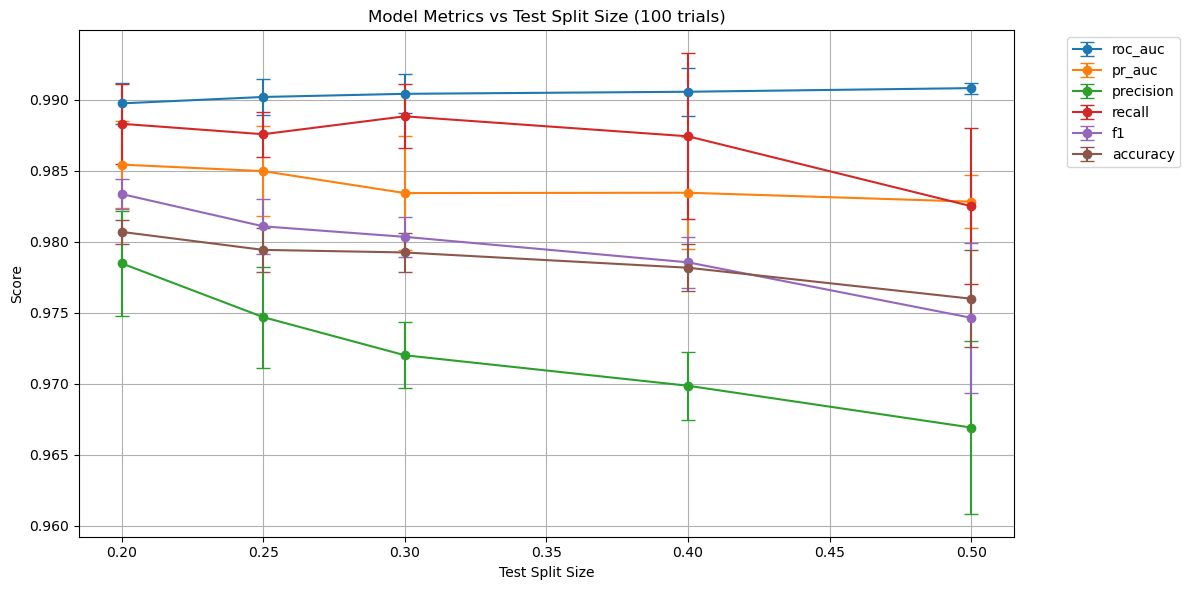

In [18]:
import xgboost
from sklearn import metrics
from joblib import Parallel, delayed

feature_cols = [col for col in polygon_id_embedding_merged.columns if 'vit' in col]
input_cols = ['polygon_id', 'class'] + feature_cols
X = polygon_id_embedding_merged[input_cols]
y = polygon_id_embedding_merged['label']

test_splits = [0.2, 0.25, 0.3, 0.4, 0.5]
n_trials = 5

def run_trial(test_size, trial):
    model = xgboost.XGBClassifier(eval_metric='logloss')
    splitter = SimpleSpatialSplitter(test_size=test_size, random_state=trial)
    X_train, X_test, y_train, y_test = splitter.split(
        X=X,
        y=y,
        polygon_id_col='polygon_id',
        class_col='class'
    )
    
    # Calculate class weights
    class_weights = dict(zip(
        *np.unique(y_train, return_counts=True)
    ))
    sample_weights = np.array([class_weights[label] for label in y_test])
    
    # Train model
    model.fit(X_train[feature_cols], y_train)
    y_pred = model.predict(X_test[feature_cols])
    y_pred_proba = model.predict_proba(X_test[feature_cols])[:, 1]
    
    # Calculate metrics with sample weights
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba, sample_weight=sample_weights)
    precision_curve, recall_curve, _ = metrics.precision_recall_curve(
        y_test, y_pred_proba, sample_weight=sample_weights
    )
    
    return {
        'test_size': test_size,
        'trial': trial,
        'roc_auc': metrics.roc_auc_score(y_test, y_pred_proba, sample_weight=sample_weights),
        'pr_auc': metrics.auc(recall_curve, precision_curve),
        'precision': metrics.precision_score(y_test, y_pred, sample_weight=sample_weights),
        'recall': metrics.recall_score(y_test, y_pred, sample_weight=sample_weights),
        'f1': metrics.f1_score(y_test, y_pred, sample_weight=sample_weights),
        'accuracy': metrics.accuracy_score(y_test, y_pred, sample_weight=sample_weights)
    }

results = Parallel(n_jobs=25, verbose=10)(
    delayed(run_trial)(test_size, trial)
    for test_size in test_splits
    for trial in range(n_trials)
)

# Reorganize results
metrics_dict = {split: [] for split in test_splits}
for trial_result in results:
    metrics_dict[trial_result['test_size']].append({
        k:v for k,v in trial_result.items() if k not in ['test_size', 'trial']
    })

# Calculate means and standard deviations
mean_metrics = []
std_metrics = []

for test_size in test_splits:
    trial_df = pd.DataFrame(metrics_dict[test_size])
    mean_metrics.append({
        'test_split': test_size,
        **trial_df.mean().to_dict()
    })
    std_metrics.append(trial_df.std().to_dict())

# Create DataFrames
df_mean = pd.DataFrame(mean_metrics).set_index('test_split')
df_std = pd.DataFrame(std_metrics, index=test_splits)

# Plot with error bars
plt.figure(figsize=(12, 6))
for column in df_mean.columns:
    plt.errorbar(test_splits, df_mean[column], yerr=df_std[column], 
                marker='o', label=column, capsize=5)

plt.title('Model Metrics vs Test Split Size (100 trials)')
plt.xlabel('Test Split Size')
plt.ylabel('Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


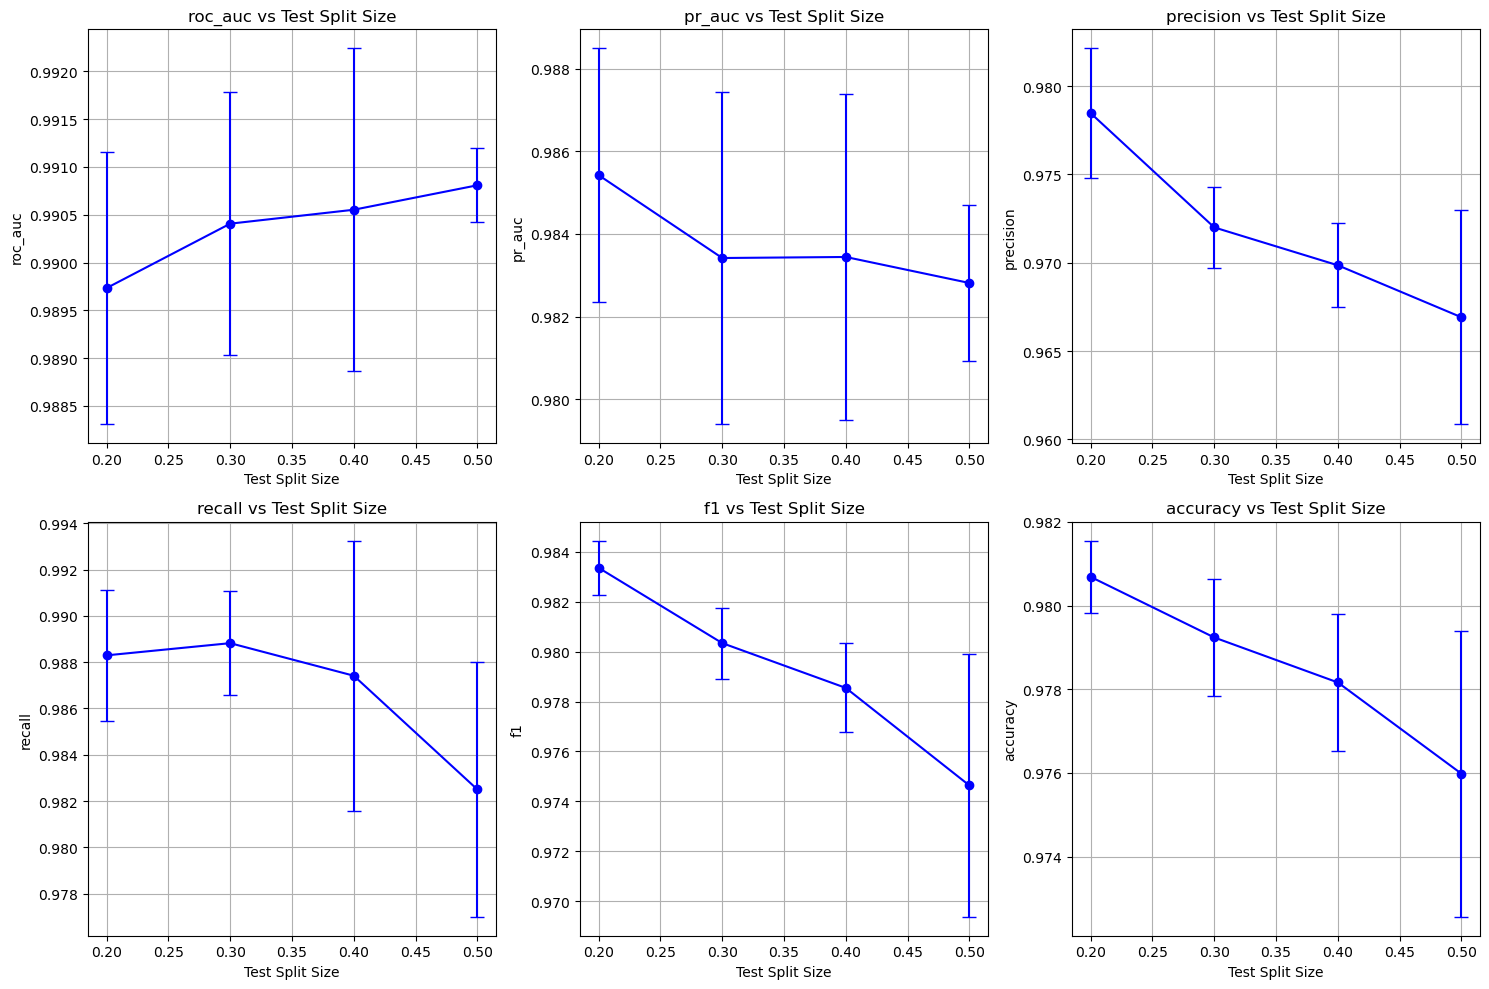

In [19]:
# Create separate plots for each metric
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

plot_splits = [0.2, 0.3, 0.4, 0.5]

for idx, column in enumerate(df_mean.columns):
    axes[idx].errorbar(plot_splits, df_mean.loc[plot_splits, column], yerr=df_std.loc[plot_splits, column],
                      marker='o', capsize=5, color='blue')
    axes[idx].set_title(f'{column} vs Test Split Size')
    axes[idx].set_xlabel('Test Split Size')
    axes[idx].set_ylabel(column)
    axes[idx].grid(True)

# # Hide the empty subplot
# axes[-1].set_visible(False)

plt.tight_layout()
plt.savefig('spatial_stratification_metrics.png', dpi=300)

In [20]:
cr_polygons = gpd.read_file("gs://demeter-labs/tea/geometries/ra_data/subsets/CostaRica_Coffee_polygons.geojson")
cr_points = gpd.read_file("gs://demeter-labs/tea/geometries/ra_data/subsets/CostaRica_Coffee_points.geojson")

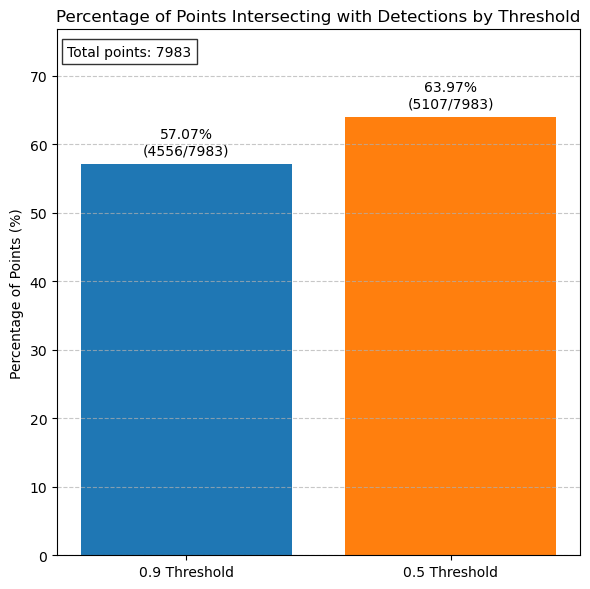

In [26]:
detections = gpd.read_parquet("gs://demeter-labs/coffee/detections/tile_classifier_predictions_v0_costa-rica_posw1.0_prob_0.9_postprocess.parquet")
detections_5 = gpd.read_parquet("gs://demeter-labs/coffee/detections/tile_classifier_predictions_v0_costa-rica_posw1.0_prob_0.5_postprocess.parquet")

# Check how many points intersect with our detections geodataframes
intersecting_points = gpd.sjoin(cr_points[['geometry']], detections[['geometry']], how='inner', predicate='intersects')
intersecting_points_5 = gpd.sjoin(cr_points[['geometry']], detections_5[['geometry']], how='inner', predicate='intersects')

# Calculate metrics
total_points = len(cr_points)
points_intersecting_09 = len(intersecting_points)
points_intersecting_05 = len(intersecting_points_5)
pct_intersecting_09 = points_intersecting_09/total_points*100
pct_intersecting_05 = points_intersecting_05/total_points*100

# Create bar chart
fig, ax = plt.figure(figsize=(6, 6)), plt.gca()
thresholds = ['0.9 Threshold', '0.5 Threshold']
percentages = [pct_intersecting_09, pct_intersecting_05]
bars = ax.bar(thresholds, percentages, color=['#1f77b4', '#ff7f0e'])

# Add data labels on bars
for bar, pct, count in zip(bars, percentages, [points_intersecting_09, points_intersecting_05]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{pct:.2f}%\n({count}/{total_points})',
            ha='center', va='bottom')

# Add chart labels
ax.set_title('Percentage of Points Intersecting with Detections by Threshold')
ax.set_ylabel('Percentage of Points (%)')
ax.set_ylim(0, max(percentages) * 1.2)  # Add some space for the labels
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add text with total points
ax.text(0.02, 0.95, f'Total points: {total_points}', transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()

/tmp/ipykernel_1099597/1996003665.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cr_polygons_union = cr_polygons.unary_union
/tmp/ipykernel_1099597/1996003665.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  detections_union = detections.unary_union
/tmp/ipykernel_1099597/1996003665.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  detections_5_union = detections_5.unary_union


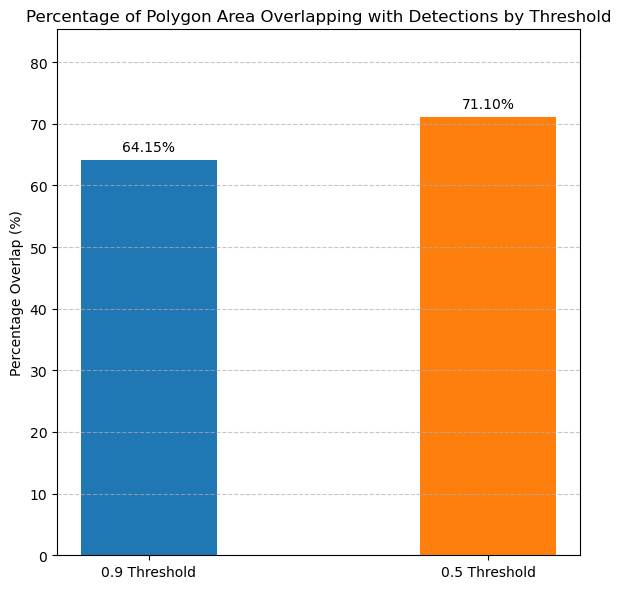

In [25]:
# Calculate unary unions
cr_polygons_union = cr_polygons.unary_union
detections_union = detections.unary_union
detections_5_union = detections_5.unary_union

# Calculate intersection areas
intersection_09 = cr_polygons_union.intersection(detections_union)
intersection_05 = cr_polygons_union.intersection(detections_5_union)

# Calculate areas
cr_area = cr_polygons_union.area
intersection_09_area = intersection_09.area
intersection_05_area = intersection_05.area

# Calculate overlap percentages
pct_overlap_09 = (intersection_09_area / cr_area) * 100
pct_overlap_05 = (intersection_05_area / cr_area) * 100

# Create bar chart with thinner bars
fig, ax = plt.figure(figsize=(6, 6)), plt.gca()
thresholds = ['0.9 Threshold', '0.5 Threshold']
percentages = [pct_overlap_09, pct_overlap_05]
bars = ax.bar(thresholds, percentages, color=['#1f77b4', '#ff7f0e'], width=0.4)

# Add data labels on bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{pct:.2f}%',
            ha='center', va='bottom')

# Add chart labels
ax.set_title('Percentage of Polygon Area Overlapping with Detections by Threshold')
ax.set_ylabel('Percentage Overlap (%)')
ax.set_ylim(0, max(percentages) * 1.2)  # Add some space for the labels
ax.grid(axis='y', linestyle='--', alpha=0.7)

# # Add text with total area
# ax.text(0.02, 0.95, f'Total polygon area: {cr_area:.2f} sq units', transform=ax.transAxes,
#         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()

In [27]:
other_crops = gpd.read_file("gs://demeter-labs/coffee/geometries/Mesoamerica_otherCrops_Final.geojson")
other_crops_cr = other_crops.loc[(other_crops['country'] == 'Costa Rica') & (other_crops['crop'] != 'Coffee')]

In [31]:
import shapely
unique_crops = other_crops_cr['crop'].unique()

# Create a dataframe to store results
overlap_results = []

# Process each crop
for crop in unique_crops:
    # Filter for this crop
    crop_data = other_crops_cr[other_crops_cr['crop'] == crop]
    
    # Convert to regular polygons (remove Z dimension)
    # Handle both Polygon and MultiPolygon geometries
    def convert_geometry(geom):
        if isinstance(geom, shapely.geometry.MultiPolygon):
            # Process each polygon in the multipolygon
            polygons = []
            for poly in geom.geoms:
                polygons.append(shapely.geometry.Polygon([(p[0], p[1]) for p in poly.exterior.coords]))
            return shapely.geometry.MultiPolygon(polygons)
        else:
            # Process single polygon
            return shapely.geometry.Polygon([(p[0], p[1]) for p in geom.exterior.coords])
    
    crop_data['geometry'] = crop_data['geometry'].apply(convert_geometry)
    
    # Create unary union
    crop_union = crop_data.unary_union
    
    # Calculate intersection areas
    intersection_09 = crop_union.intersection(detections_union)
    intersection_05 = crop_union.intersection(detections_5_union)
    
    # Calculate areas
    crop_area = crop_union.area
    intersection_09_area = intersection_09.area
    intersection_05_area = intersection_05.area
    
    # Calculate overlap percentages
    pct_overlap_09 = (intersection_09_area / crop_area) * 100 if crop_area > 0 else 0
    pct_overlap_05 = (intersection_05_area / crop_area) * 100 if crop_area > 0 else 0
    
    # Add to results
    overlap_results.append({
        'crop': crop,
        'area_ha': crop_data['Area_ha'].sum(),
        'pct_overlap_09': pct_overlap_09,
        'pct_overlap_05': pct_overlap_05
    })

# Convert to dataframe and display
overlap_df = pd.DataFrame(overlap_results)
overlap_df.sort_values('area_ha', ascending=False, inplace=True)
overlap_df

/home/christopher.x.ren/miniforge3/envs/ei-nb-v2/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_1099597/3046633708.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  crop_union = crop_data.unary_union
/home/christopher.x.ren/miniforge3/envs/ei-nb-v2/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

,crop,area_ha,pct_overlap_09,pct_overlap_05
1,Pineapple fruit,13121.736,0.0,0.0
2,Banana,3621.478,0.0,0.0
0,White Pepper,610.104,0.0,0.0
3,Cassava,210.263,0.0,0.0
4,Other ornamental plants,91.955,0.0,0.0
5,Cranberry fruit,9.340,0.0,0.0
6,Strawberry fruit,9.340,0.0,0.0
7,Blackberry fruit,9.340,0.0,0.0
8,Physalis / Cape gooseberry,9.340,0.0,0.0
9,Raspberry fruit,9.340,0.0,0.0
